# SCANIA APS Analysis - Merging the old Fashion Feature Engineering with Machine Learning Methods for a Inference and Prediction Solution

## Overview
The notebook present here tries to solve this challenge by the follow **framework**

+ **Missing Data Analysis**
    - Remove variables that present a NA % higher than *5%* (this is a recomendation from studies on topics from MDA)
    - Data Imputation using *mice* package
+ **Correlation Analysis**
    - Through *spearman correlation* and *0.9 cut-off* the high correlated variables was remove from predictors set to avoid noise.
    - Some variables present a maximum correlation, something akward.
+ **PCA for Dimensionality Reduction**
    - Through *PCA* was defined *15 components* that presents a sum of *60% of explained variance* to compose the new predictor set
+ **Generated Models**
    - Generate and predict the test set using *Random Forests*
    - Generate and predict the test set using *XGBoost*
    - Analyze the cost for both models
+ **Inference Way Back Machine**
    - Present the original variables that can be candidates to be the root cause
+ **Conclusions and Future Development**
    - In this part I will discuss the framework and present some doubts to the community!

## Objective
The main goal from this framework is to present a structure capable to do *Inference* on this problem besides *Prediction*. Through models such as *XGBoost* and *Random Forest* it is possible to adquire a information called *Variable Importance* that shows the most important variables for the model. As my variables are *Principal Components* it is possible to analyze the *loadings* from PCA Analysis to seee the most impactfull original variables was (with the higher *loadings*). This would help the company prevent the problem in his root!

## Code

### Importing data and Library

In [1]:
library(qcc)
library(mice)
library(caret)
library(xgboost)
library(corrplot)
library(randomForest)

# IMPORTING TRAINING SET (df) AND TEST SET (dt)
dTrainRaw <- read.table(file = '../input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set.csv', sep = ',', dec = '.',na.strings = 'na', header = T, stringsAsFactors = F)
dTestRaw <- read.table(file = '../input/aps-failure-at-scania-trucks-data-set/aps_failure_test_set.csv', sep = ',', dec = '.',na.strings = 'na', header = T, stringsAsFactors = F)

Package 'qcc' version 2.7

Type 'citation("qcc")' for citing this R package in publications.

Loading required package: lattice


Attaching package: ‘mice’


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


corrplot 0.84 loaded

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




### Missing Data Analysis

In [2]:
### MCAR or MNAR (?) - Given the situation from the challenge will be considered MCAR

### Define variables NA % that contains > 5% missing values and remove them! (Based on a golden rule)
#### Analyze % NA
var_pct_na <- stack(100*colSums(is.na(dTrainRaw))/nrow(dTrainRaw))
#### How many variables have more than 5% NA
passing_vars <- as.character(var_pct_na[var_pct_na$values < 5,'ind'])
#### Change df & dt to remove Misssing vars
dTrainRaw <- dTrainRaw[passing_vars]
dTestRaw <- dTestRaw[passing_vars]

### Break DF & DT into X and Y
#### TEST
dTestRaw_x <- dTestRaw[-1]
dTestRaw_y <- dTestRaw[1]
dTestRaw_y$class[dTestRaw_y$class == "neg"] <- 0
dTestRaw_y$class[dTestRaw_y$class == "pos"] <- 1
#### TRAIN
dTrainRaw_x <- dTrainRaw[-1]
dTrainRaw_y <- dTrainRaw[1]
dTrainRaw_y$class[dTrainRaw_y$class == "neg"] <- 0
dTrainRaw_y$class[dTrainRaw_y$class == "pos"] <- 1

### PS: AVOID GOLDEN RULE - ELIMINATE SAMPLES THAT CONTAINS >50% NA VALUES (Based on a golden rule)

In [3]:
### Data Imputation with CART Imputations - m and maxit parameters are in the lower value to speed the code (took a lot to run this imputation)
#### TRAIN - Find NA values
tempData <- mice(data = dTrainRaw_x, method = 'cart', m = 1, maxit = 1)
#### TRAIN - Insert values into the dataset
dTrainRaw_x <- complete(tempData, 1)
#### TEST - Find NA values
tempData <- mice(data = dTestRaw_x, method = 'cart', m = 1, maxit = 1)
#### Test - Insert values into the dataset
dTestRaw_x <- complete(tempData, 1)


 iter imp variable
  1   1  ae_000  af_000  ag_000  ag_001  ag_002  ag_003  ag_004  ag_005  ag_006  ag_007  ag_008  ag_009  ai_000  aj_000  al_000  am_0  an_000  ao_000  ap_000  aq_000  ar_000  as_000  at_000  au_000  av_000  ax_000  ay_000  ay_001  ay_002  ay_003  ay_004  ay_005  ay_006  ay_007  ay_008  ay_009  az_000  az_001  az_002  az_003  az_004  az_005  az_006  az_007  az_008  az_009  ba_000  ba_001  ba_002  ba_003  ba_004  ba_005  ba_006  ba_007  ba_008  ba_009  bb_000  bc_000  bd_000  be_000  bf_000  bg_000  bh_000  bi_000  bj_000  bs_000  by_000  bz_000  cb_000  ce_000  ci_000  cj_000  ck_000  cn_000  cn_001  cn_002  cn_003  cn_004  cn_005  cn_006  cn_007  cn_008  cn_009  cp_000  cs_000  cs_001  cs_002  cs_003  cs_004  cs_005  cs_006  cs_007  cs_008  cs_009  dd_000  de_000  dn_000  do_000  dp_000  dq_000  dr_000  ds_000  dt_000  du_000  dv_000  dx_000  dy_000  dz_000  ea_000  ee_000  ee_001  ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008  ee_009  ef_000  eg_000


Warning message:
“Number of logged events: 125”



 iter imp variable
  1   1  ae_000  af_000  ag_000  ag_001  ag_002  ag_003  ag_004  ag_005  ag_006  ag_007  ag_008  ag_009  ai_000  aj_000  al_000  am_0  an_000  ao_000  ap_000  aq_000  ar_000  as_000  at_000  au_000  av_000  ax_000  ay_000  ay_001  ay_002  ay_003  ay_004  ay_005  ay_006  ay_007  ay_008  ay_009  az_000  az_001  az_002  az_003  az_004  az_005  az_006  az_007  az_008  az_009  ba_000  ba_001  ba_002  ba_003  ba_004  ba_005  ba_006  ba_007  ba_008  ba_009  bb_000  bc_000  bd_000  be_000  bf_000  bg_000  bh_000  bi_000  bj_000  bs_000  by_000  bz_000  cb_000  ce_000  ci_000  cj_000  ck_000  cn_000  cn_001  cn_002  cn_003  cn_004  cn_005  cn_006  cn_007  cn_008  cn_009  cp_000  cs_000  cs_001  cs_002  cs_003  cs_004  cs_005  cs_006  cs_007  cs_008  cs_009  dd_000  de_000  dn_000  do_000  dp_000  dq_000  dr_000  ds_000  dt_000  du_000  dv_000  dx_000  dy_000  dz_000  ea_000  ee_000  ee_001  ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008  ee_009  ef_000  eg_000


Warning message:
“Number of logged events: 127”


In [4]:
### Data Imputation with mean column values - Apparently, some values still not imputed by mice package
NA2mean <- function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))
#### TRAIN - Insert values into the dataset(remaining)
dTrainRaw_x[] <- lapply(dTrainRaw_x, NA2mean)
#### Test - Insert values into the dataset(remaining)
dTestRaw_x[] <- lapply(dTestRaw_x, NA2mean)

### Correlation Analysis

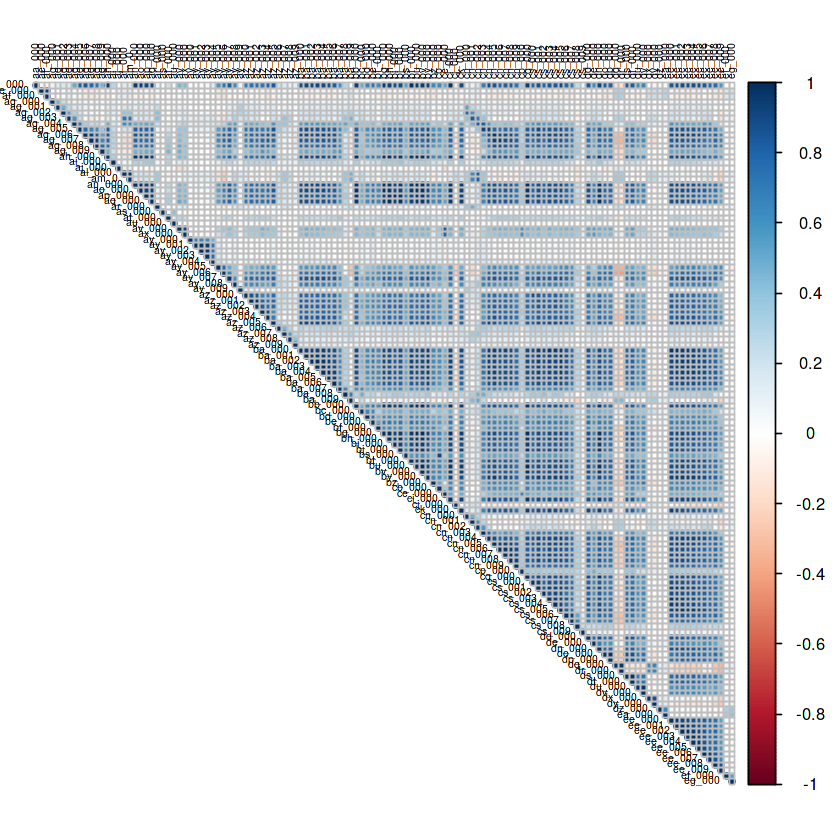

In [5]:
### Calculate SD to find constant variables to DROP!
sd_analysis <- sapply(dTrainRaw_x, sd, na.rm = TRUE)
#### TRAIN SET drop constant vars
dTrainRaw_x <- dTrainRaw_x[setdiff(colnames(dTrainRaw_x), names(sd_analysis[sd_analysis == 0]))]
#### TEST SET drop constant vars
dTestRaw_x <- dTestRaw_x[setdiff(colnames(dTestRaw_x), names(sd_analysis[sd_analysis == 0]))]

### Correlation Calculation
cor_matrix <- cor(x = dTrainRaw_x, method = 'spearman', use = 'complete.obs')

### Correlation Plot
corrplot(corr = cor_matrix, type = "upper", tl.cex = 0.5, tl.pos = "td", tl.col = 'black')

As was mentioned in the **Overview** section, there is a lot of high correlation between those variables as show by the great quantity of blue squares

In [6]:
### Drop High Correlated Variables using caret package
hcv <- caret::findCorrelation(x = cor_matrix, cutoff = 0.9, verbose = T)
hcv <- sort(hcv)
#### TRAIN DROP
dTrainRaw_x <- dTrainRaw_x[,-c(hcv)]
#### TEST DROP
dTestRaw_x <- dTestRaw_x[,-c(hcv)]


 Combination row 2 and column 3 is above the cut-off, value = 0.946 
 	 Flagging column 3 
 Combination row 10 and column 11 is above the cut-off, value = 0.921 
 	 Flagging column 10 
 Combination row 11 and column 12 is above the cut-off, value = 0.916 
 	 Flagging column 11 
 Combination row 1 and column 14 is above the cut-off, value = 0.948 
 	 Flagging column 14 
 Combination row 17 and column 18 is above the cut-off, value = 0.989 
 	 Flagging column 17 
 Combination row 1 and column 19 is above the cut-off, value = 0.951 
 	 Flagging column 19 
 Combination row 14 and column 19 is above the cut-off, value = 0.985 
 	 Flagging column 19 
 Combination row 1 and column 20 is above the cut-off, value = 0.953 
 	 Flagging column 20 
 Combination row 14 and column 20 is above the cut-off, value = 0.976 
 	 Flagging column 14 
 Combination row 19 and column 20 is above the cut-off, value = 0.992 
 	 Flagging column 19 
 Combination row 14 and column 21 is above the cut-off, value = 0

More than 50 variables was remove in this phase

### PCA for Dimensionality Reduction

In [7]:
### PCA Calc
pca <- prcomp(x = dTrainRaw_x, center = T, scale. = T)

### DataFrame to hold Variance Explained
var_explained = round(pca$sdev^2/sum(pca$sdev^2)*100, 2)
var_explained = data.frame(c(1:length(pca$sdev)),var_explained)
names(var_explained)[1] = 'PCs'
names(var_explained)[2] = 'Variance'

### Pareto Plot
PCA = pca$sdev^2
names(PCA) = paste0('PC', var_explained$PCs)

      
Pareto chart analysis for PCA
          Frequency    Cum.Freq.   Percentage Cum.Percent.
  PC1  1.519336e+01 1.519336e+01 2.053156e+01 2.053156e+01
  PC2  4.907151e+00 2.010051e+01 6.631285e+00 2.716285e+01
  PC3  3.464769e+00 2.356528e+01 4.682120e+00 3.184497e+01
  PC4  2.402594e+00 2.596787e+01 3.246749e+00 3.509172e+01
  PC5  2.120351e+00 2.808822e+01 2.865340e+00 3.795706e+01
  PC6  1.893889e+00 2.998211e+01 2.559309e+00 4.051637e+01
  PC7  1.806828e+00 3.178894e+01 2.441659e+00 4.295802e+01
  PC8  1.769316e+00 3.355825e+01 2.390967e+00 4.534899e+01
  PC9  1.624453e+00 3.518271e+01 2.195206e+00 4.754420e+01
  PC10 1.570448e+00 3.675315e+01 2.122227e+00 4.966642e+01
  PC11 1.435055e+00 3.818821e+01 1.939264e+00 5.160569e+01
  PC12 1.291692e+00 3.947990e+01 1.745530e+00 5.335122e+01
  PC13 1.250143e+00 4.073005e+01 1.689383e+00 5.504060e+01
  PC14 1.226235e+00 4.195628e+01 1.657074e+00 5.669768e+01
  PC15 1.157937e+00 4.311422e+01 1.564780e+00 5.826246e+01
  PC16 1.152001e+00

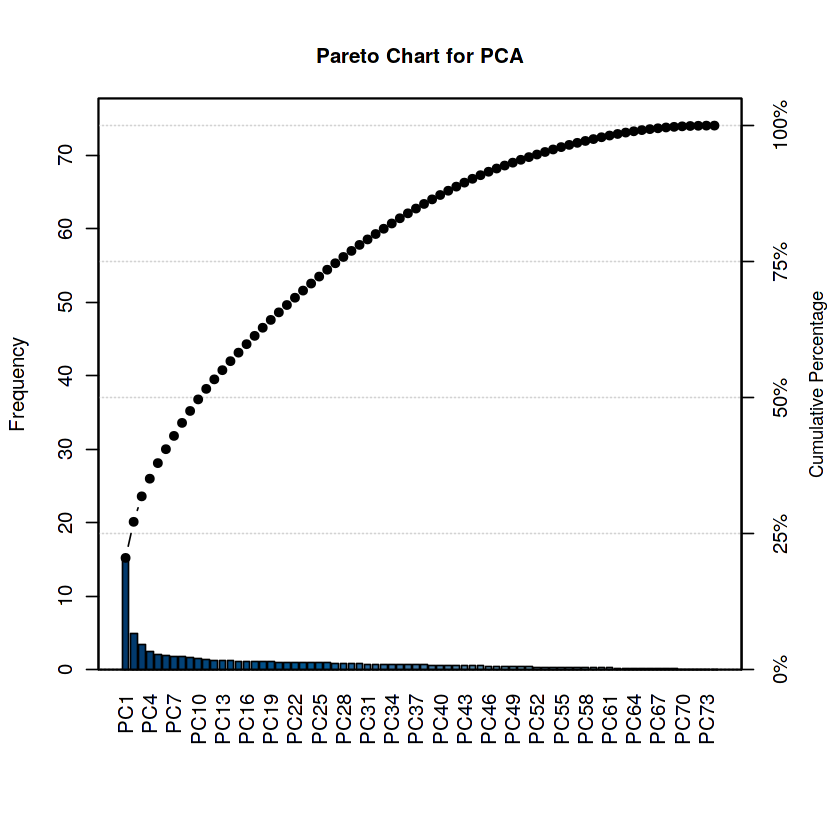

In [8]:
plt <- qcc::pareto.chart(PCA)
plt

This **Pareto Plot** shows most of the *explained variance* (represented by the column *frequency*) are in the first PCs

In [9]:
### Define a predictors based on PCs - 60% Explained Var
dTrainPCA_x <-  data.frame(pca$x)
dTrainPCA_x <-  dTrainPCA_x[1:34]

### Transform test set to PC Domain
dTestPCA_x <- predict(pca, newdata = dTestRaw_x)
dTestPCA_x  <- as.data.frame(dTestPCA_x )
dTestPCA_x  <- dTestPCA_x[1:34]

### Model Generated - Random Forests

mtry = 5  OOB error = 0.91% 
Searching left ...
mtry = 3 	OOB error = 0.94% 
-0.03308824 0.05 
Searching right ...
mtry = 10 	OOB error = 0.84% 
0.07904412 0.05 
mtry = 20 	OOB error = 0.87% 
-0.03992016 0.05 


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 15593   147
         1    32   228
                                          
               Accuracy : 0.9888          
                 95% CI : (0.9871, 0.9904)
    No Information Rate : 0.9766          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7126          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9980          
            Specificity : 0.6080          
         Pos Pred Value : 0.9907          
         Neg Pred Value : 0.8769          
             Prevalence : 0.9766          
         Detection Rate : 0.9746          
   Detection Prevalence : 0.9838          
      Balanced Accuracy : 0.8030          
                                          
       'Positive' Class : 0               
                  

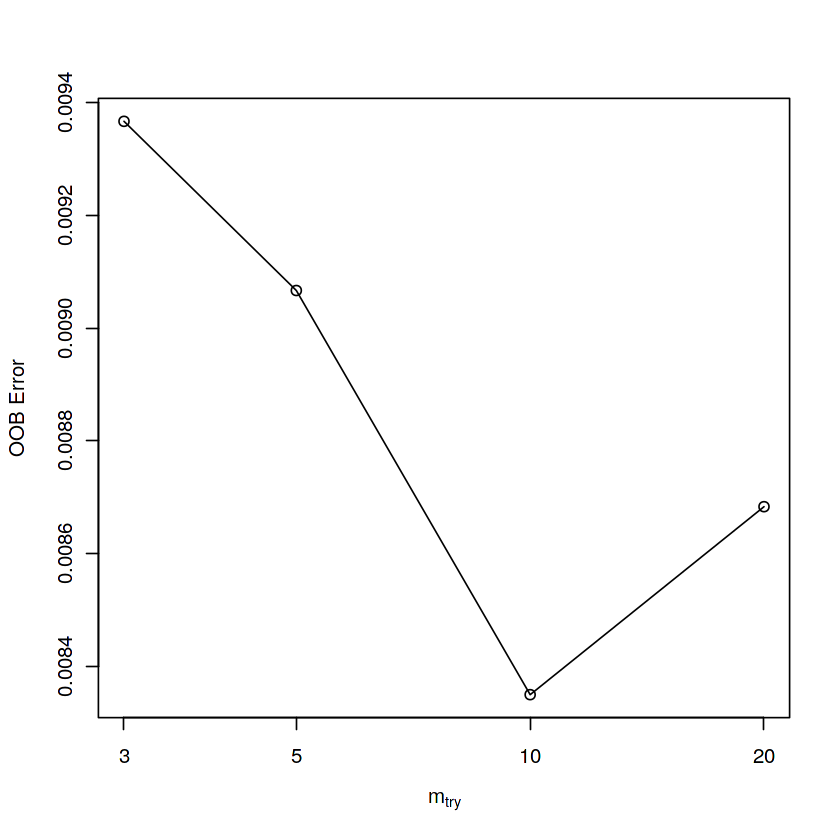

In [10]:
### Data transform
dTrainRF <- cbind(as.factor(dTrainRaw_y$class), dTrainPCA_x)
colnames(dTrainRF)[1] <- 'class'
dTestRF <- cbind(as.factor(dTestRaw_y$class), dTestPCA_x)
colnames(dTestRF)[1] <- 'class'

### Model Creation
rfModel <- randomForest::tuneRF(x = dTrainRF[-1], y = dTrainRF$class, doBest = T)

### Model Prediction
rfPred <- predict(rfModel, newdata = dTestRF)

### Confusion Matrix
rfCM <- confusionMatrix(data = rfPred, reference = dTestRF$class)
rfCM

In [11]:
### Cost for Random Forests Predictions in Coin
500*rfCM$table[1,2] + 10*rfCM$table[2,1]

[1] 73820

### Model Generated - XGBoost

In [12]:
### Data transform
dTrainXG <- xgb.DMatrix(label = as.matrix(dTrainRaw_y), data = as.matrix(dTrainPCA_x))
dTestXG <- xgb.DMatrix(label = as.matrix(dTestRaw_y), data = as.matrix(dTestPCA_x))

### Model Creation
xgbModel <- xgboost(data = dTrainXG,
                    nrounds = 5,
                    objective = "binary:logistic",
                    verbose = 1)

### Model Prediction
xgbPred <- predict(xgbModel, dTestXG)
xgbPred <- as.numeric(xgbPred > 0.5)

### Confusion Matrix
xgbCM <- confusionMatrix(data = as.factor(xgbPred), reference = as.factor(dTestRaw_y$class))
xgbCM

[1]	train-error:0.009333 
[2]	train-error:0.008417 
[3]	train-error:0.007533 
[4]	train-error:0.006850 
[5]	train-error:0.006533 


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 15581   175
         1    44   200
                                          
               Accuracy : 0.9863          
                 95% CI : (0.9844, 0.9881)
    No Information Rate : 0.9766          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6395          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9972          
            Specificity : 0.5333          
         Pos Pred Value : 0.9889          
         Neg Pred Value : 0.8197          
             Prevalence : 0.9766          
         Detection Rate : 0.9738          
   Detection Prevalence : 0.9848          
      Balanced Accuracy : 0.7653          
                                          
       'Positive' Class : 0               
                  

In [13]:
### Cost for XGBoost Predictions
500*xgbCM$table[1,2] + 10*xgbCM$table[2,1]

[1] 87940

### Inference Way Back Machine!

Unfortunately, both models did not performed so well. The *possible reasons* and furthers discussions will be presented at the last topic. Here, I analyzed the most important variable for the RF model and then see through the *PCA Loadings* the most impactfull original variable for that specific PC.

#### Variable Importance in RF Model

In [14]:
varImp(rfModel)

,Overall
,<dbl>
PC1,291.45250
PC2,186.77345
PC3,153.99149
PC4,38.78764
PC5,49.72811
PC6,98.53735
PC7,40.85009
PC8,29.32841
PC9,106.83974


As expected, the first PC present the higher importance Followed close by the others 2 PCs

#### Most Impactfull Original Variable for Random Forest Model
I will present the highers first three *loadings* for PC1, as a example to find the possible root cause for this problem.

**PS**: Remember that a *loading* is not in a interval, so is not a %!

In [15]:
head(sort(pca$rotation[,1], decreasing = T),3)

az_005    cn_003    ag_004 
0.2144455 0.2116395 0.2096393

### Conclusions and Future Development
Unfortunately, my framework did not go as planned. I would love to have some advices in how to improve it through the comments or email!

The reasons that I think did not work so well as:
- Lack of a **tuning system** for the *Hyper parameters* for those models
- My decision in the pre-processing part as the Missing Analysis decision (variables with <5% of NA) and dropping Correlated variables (this discussion as I see on blogs and foruns it is not so trivial)
- The unbalanced data.
- My imputation Method could made some significant changes in my results. I used the original dataset, most because there was a lot of variables that I did not believe could be placed (80% of missing values is too much), so I had to use other method that did not prove to work well (CART in mice package)

As I said, I want to improve this framework so if you have any suggestion, please
# DO IT!